In [1]:
from skimage import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

In [2]:
data_path = '/Users/junhakim/Desktop/real-time-squat-classifier/data/Pose_Dataset/'

channel = 256

batch_size = 16
learning_rate = 1e-4
num_epochs = 5

In [3]:
labels = ['bad_back_round', 'bad_back_warp', 'bad_head', 'bad_innner_thigh', 'bad_shallow', 'bad_toe', 'good']
paths = {'bad_back_round': 0,
             'bad_back_warp': 0,
             'bad_head': 0,
             'bad_innner_thigh': 0,
             'bad_shallow': 0,
             'bad_toe': 0,
             'good': 0}

for label in labels:
    paths[label] = data_path + label + "/1115_3djoints_index"

json_files = {'bad_back_round': 0,
                  'bad_back_warp': 0,
                  'bad_head': 0,
                  'bad_innner_thigh': 0,
                  'bad_shallow': 0,
                  'bad_toe': 0,
                  'good': 0}

for label in labels:
    json_files[label] = [pos_json for pos_json in os.listdir(paths[label]) if pos_json.endswith('.json')]

data = {'bad_back_round': [], 'bad_back_warp': [], 'bad_head': [], 'bad_innner_thigh': [], 'bad_shallow': [],
            'bad_toe': [], 'good': []}

In [4]:
for label in tqdm(labels):
    for single_file in json_files[label]:
        file_path = paths[label] + "/" + single_file
        with open(file_path, 'r') as fp:
            data[label].append(json.load(fp))

data_numpy = {}
for label in labels:
    label_list = []
    for i in tqdm(range(len(data[label]))):
        my_list = []
        for j in range(300):
            my_list.append(data[label][i][str(j)]['3d_joint'])  # 모델이 무거운 관계로 data sampling을 해서 171개의 일부를 뽑아줄 수 있다.
        label_list.append(my_list)
    label_numpy = np.array(label_list)
    data_numpy[label] = label_numpy

100%|██████████| 293/293 [00:00<00:00, 8700.52it/s]


/opt/anaconda3/envs/pythonnew/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


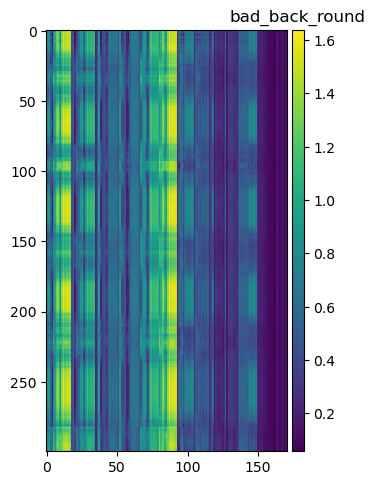

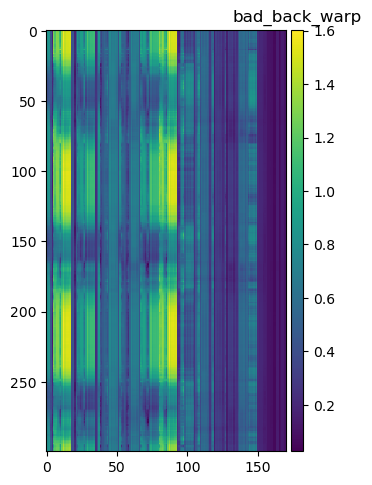

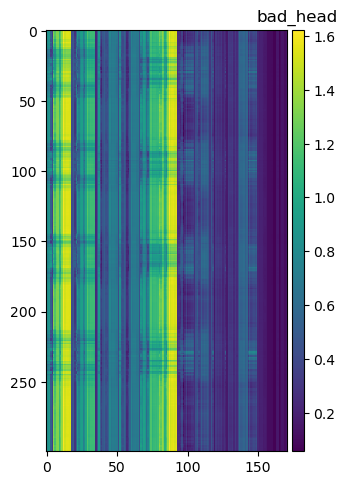

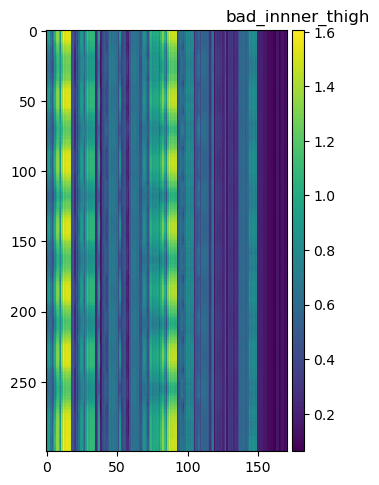

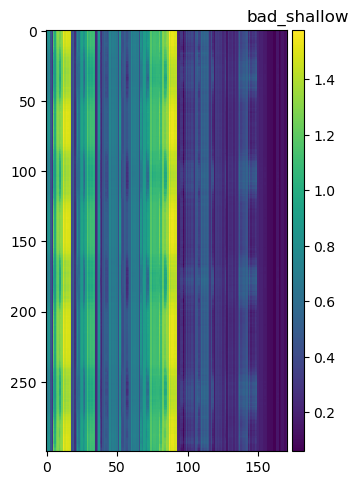

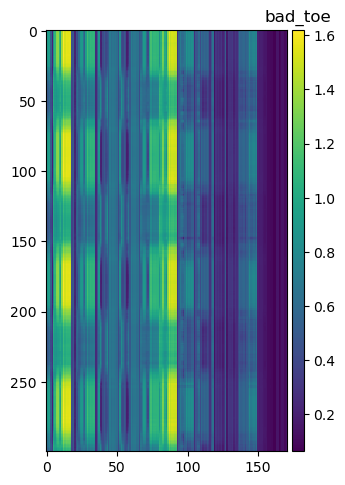

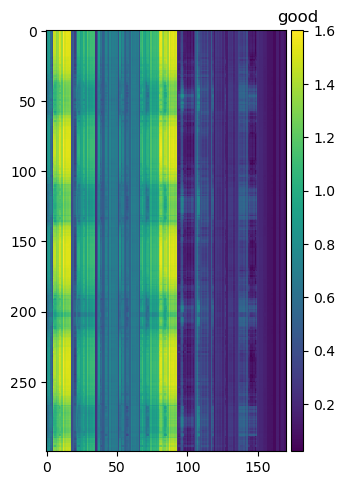

In [5]:
# 형태 이미지 출력
for label in labels:
    io.imshow(data_numpy[label][0])
    plt.title(label)
    plt.show()

In [6]:
# 푸리에 변환 (2차원)
f2 = np.fft.fft2(data_numpy['bad_back_round'][0])
shift = np.fft.fftshift(f2)


mag = np.log(np.abs(shift))
phase = np.angle(shift)

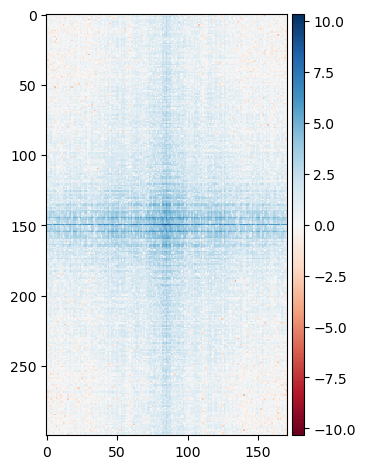

In [7]:
# magnitude
io.imshow(mag)
plt.show()

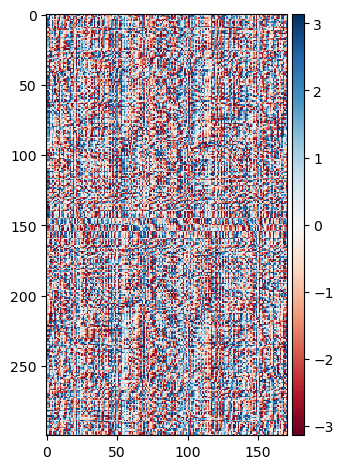

In [8]:
# angle
io.imshow(phase)
plt.show()

In [9]:
# 각 길이별 magnitude 계산 -> 주파수는 magnitude 별로 거의 비슷하게 나와야함
# 171 * 1 magnitude + 171 * 1 phase array
fft_dataset = {}
for label in labels:
    size = len(data_numpy[label])
    fft = np.zeros((size,171,2))
    for i in tqdm(range(size), desc=label):
        _, dim  = data_numpy[label][i].shape

        for idx in range(dim):
            signal_idx = data_numpy[label][i][:,idx]
            """
            plt.plot(signal_idx)
            plt.title(label+" origin")
            plt.show()
            """
            fft_idx = np.fft.fft(signal_idx)
            N = len(fft_idx)
            n = np.arange(N)
            ## get the sampling rate
            sr = 1 / 300
            T = N/sr
            freq = n/T
            """
            plt.figure(figsize = (12, 6))
            plt.plot(freq, np.abs(fft_idx), 'b')
            plt.xlabel('Freq (Hz)')
            plt.ylabel('FFT Amplitude |X(freq)|')
            plt.show()
            """
            # convert frequency to hour
            t_h = (1/freq / 300)[1:-100]
            frame = (np.abs(fft_idx))[1:-100]
            """
            plt.plot(t_h[:-100], frame[:-100])
            plt.xlabel('Period ($frame$)')
            plt.show()
            break
            """
            max_idx = np.argmax(frame)
            fft[i,idx,0] = t_h[max_idx]
            fft[i,idx,1] = frame[max_idx]
    fft_dataset[label] = fft

good: 100%|██████████| 293/293 [00:00<00:00, 324.01it/s]


In [10]:
for label in labels:
    print(fft_dataset[label].shape)
    print(fft_dataset[label])

(280, 171, 2)
[[[ 60.           2.41595716]
  [ 60.          19.2446386 ]
  [ 60.          13.50746012]
  ...
  [ 60.           0.2773097 ]
  [ 60.           0.18850937]
  [ 60.           0.61762415]]

 [[ 75.           4.52607408]
  [ 75.          18.58346065]
  [ 75.          19.21504051]
  ...
  [ 75.           0.44350675]
  [ 75.           0.46141471]
  [ 75.           0.69267101]]

 [[100.           4.92012841]
  [100.          32.43866245]
  [100.          26.07964194]
  ...
  [100.           0.15636905]
  [100.           0.17976648]
  [100.           0.58327113]]

 ...

 [[100.           0.43797803]
  [100.          23.71812188]
  [100.          20.14118628]
  ...
  [100.           0.17965437]
  [100.           0.13328373]
  [100.           0.16523755]]

 [[100.           2.23382665]
  [100.          14.88506127]
  [100.          10.90544834]
  ...
  [100.           0.30362302]
  [100.           0.36456037]
  [100.           0.36930416]]

 [[ 60.           3.5415456 ]
  [ 60.   

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Input,ZeroPadding1D,BatchNormalization,AveragePooling2D, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras import activations
from sklearn.utils import shuffle
from tensorflow.keras import regularizers

In [54]:
train_samples={}
valid_samples={}
test_samples={}
labels=['bad_back_round','bad_back_warp','bad_head','bad_innner_thigh','bad_shallow','bad_toe','good']
label_encoding={'bad_back_round':[1,0,0,0,0,0,0],'bad_back_warp':[0,1,0,0,0,0,0],'bad_head':[0,0,1,0,0,0,0],'bad_innner_thigh':[0,0,0,1,0,0,0],'bad_shallow':[0,0,0,0,1,0,0],'bad_toe':[0,0,0,0,0,1,0],'good':[0,0,0,0,0,0,1]}
train_labels=[]
valid_labels=[]
test_labels=[]
train_x=[]
valid_x=[]
test_x=[]



#train: valid: test = 7:2:1로 나눠봄
for label in labels:
    np.random.shuffle(fft_dataset[label])
    entire_sample=fft_dataset[label]
    np.random.shuffle(entire_sample)
    num_train=int(0.7*len(entire_sample))
    num_valid=int(0.9*len(entire_sample))
    train_samples[label],valid_samples[label],test_samples[label]=entire_sample[:num_train,:],entire_sample[num_train:num_valid,:],entire_sample[num_valid:,:]



for label in labels:
    #print("----"+label+"-----")
    print(test_samples[label].shape)
    for i in range(train_samples[label].shape[0]):
        train_labels.append(label_encoding[label])
        train_x.append(train_samples[label][i,:,:])

    for i in range(valid_samples[label].shape[0]):
        valid_labels.append(label_encoding[label])
        valid_x.append(valid_samples[label][i,:,:])

    for i in range(test_samples[label].shape[0]):
        test_labels.append(label_encoding[label])
        test_x.append(train_samples[label][i,:,:])

train_x=np.array(train_x)
train_labels=np.array(train_labels)

valid_x=np.array(valid_x)
valid_labels=np.array(valid_labels)
test_x=np.array(test_x)
test_labels=np.array(test_labels)



train_x,train_labels=shuffle(train_x,train_labels)
valid_x,valid_labels=shuffle(valid_x,valid_labels)
test_x,test_labels=shuffle(test_x,test_labels)
train_x = np.expand_dims(train_x,axis=3)
valid_x = np.expand_dims(valid_x,axis=3)
test_x = np.expand_dims(test_x,axis=3)
print("train_x",train_x.shape)
print("train_label",train_labels.shape)

print("test_x",test_x.shape)
print("test_label",test_labels.shape)

print("valid_x",valid_x.shape)
print("valid_label",valid_labels.shape)

(28, 171, 2)
(32, 171, 2)
(28, 171, 2)
(23, 171, 2)
(32, 171, 2)
(30, 171, 2)
(30, 171, 2)
train_x (1399, 171, 2, 1)
train_label (1399, 7)
test_x (203, 171, 2, 1)
test_label (203, 7)
valid_x (399, 171, 2, 1)
valid_label (399, 7)


In [55]:
inputs=tf.keras.Input(shape=(171,2,1))

layer1 = Conv2D(filters=10, kernel_size=(1, 2), strides=(1, 1),padding='valid',kernel_regularizer=regularizers.l2(0.01))(inputs)
layer1=BatchNormalization()(layer1)
layer1=activations.relu(layer1)

flat = Flatten()(layer1)
layer2 = Dense(171, activation='relu')(flat)
layer3 = Dense(70, activation='relu')(layer2)

drop = Dropout(0.1)(layer3)
layer4 = Dense(7, activation = 'softmax')(drop)
outputs=layer4

my_model=tf.keras.Model(inputs=inputs,outputs=outputs)

In [56]:
my_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 171, 2, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 171, 1, 10)        30        
_________________________________________________________________
batch_normalization_21 (Batc (None, 171, 1, 10)        40        
_________________________________________________________________
tf_op_layer_Relu_21 (TensorF [(None, 171, 1, 10)]      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1710)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 171)               292581    
_________________________________________________________________
dense_14 (Dense)             (None, 70)                1204

In [59]:
my_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
my_model.fit(x=train_x,y=train_labels,batch_size=10,epochs=300,validation_data=(valid_x,valid_labels),verbose=2)

Train on 1399 samples, validate on 399 samples
Epoch 1/300
1399/1399 - 5s - loss: 1.6089 - accuracy: 0.4067 - val_loss: 1.7308 - val_accuracy: 0.3534
Epoch 2/300
1399/1399 - 2s - loss: 1.5972 - accuracy: 0.4060 - val_loss: 1.7296 - val_accuracy: 0.3559
Epoch 3/300
1399/1399 - 1s - loss: 1.5956 - accuracy: 0.4110 - val_loss: 1.7285 - val_accuracy: 0.3559
Epoch 4/300
1399/1399 - 1s - loss: 1.6060 - accuracy: 0.4060 - val_loss: 1.7274 - val_accuracy: 0.3559
Epoch 5/300
1399/1399 - 1s - loss: 1.5792 - accuracy: 0.4232 - val_loss: 1.7266 - val_accuracy: 0.3584
Epoch 6/300
1399/1399 - 1s - loss: 1.5874 - accuracy: 0.3996 - val_loss: 1.7257 - val_accuracy: 0.3584
Epoch 7/300
1399/1399 - 1s - loss: 1.6139 - accuracy: 0.3939 - val_loss: 1.7248 - val_accuracy: 0.3584
Epoch 8/300
1399/1399 - 1s - loss: 1.6071 - accuracy: 0.4024 - val_loss: 1.7237 - val_accuracy: 0.3584
Epoch 9/300
1399/1399 - 1s - loss: 1.5906 - accuracy: 0.4060 - val_loss: 1.7226 - val_accuracy: 0.3584
Epoch 10/300
1399/1399 - 1

KeyboardInterrupt: 

In [60]:
results = my_model.evaluate(test_x, test_labels, batch_size=16)

203/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================